__What we are going to cover ?__
* Getting a custom dataset with pytorch
* Becoming one with the data (preparing and visualizing)
* Transforming data for use with a model
* Loading custom data with pre-built functions and custom functions
* Data Augmentation
* Building FoodVision Mini to classify (pizza, sushi, steak) images
* Comparing models with and without Data Augmentation
* Making prediction on custom data

In [51]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [52]:
# setting device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
# device = "cuda" if torch.cuda.is_available() else "cpu"
device

'mps'

# Getting a Custom Dataset With PyTorch
Our dataset is a subset of Food101 dataset. Our dataset starts with 3 classes of food and only 10% of the images.

In [53]:
# downloading the data

import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder does not exist, download and prepare it ..
if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download")
else:
    print(f"{image_path} does not exist creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # download data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download


In [54]:
# setup train and test paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Becoming one with the data (preparing and visualizing)

__Using PIL__

Image Class: pizza
Image Height And Width: 512, 512


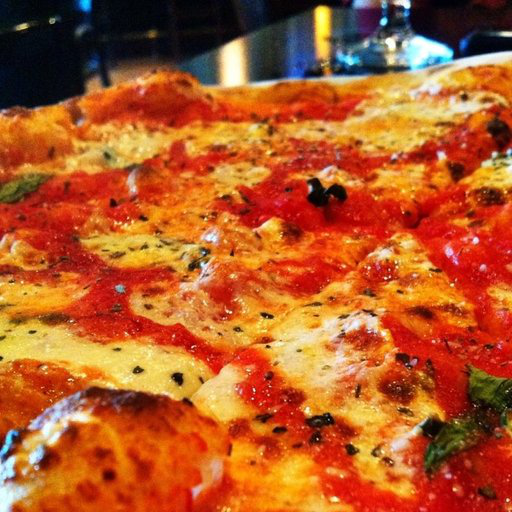

In [55]:
import random
from PIL import Image

random.seed(42)

# getting paths of all images
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select randomly from the image path list
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# print metadata
print(f"Image Class: {random_image_class}")
print(f"Image Height And Width: {img.height}, {img.width}")
img

__Using Matplotlib__

Image Class: steak
Image Shape: (384, 512, 3)


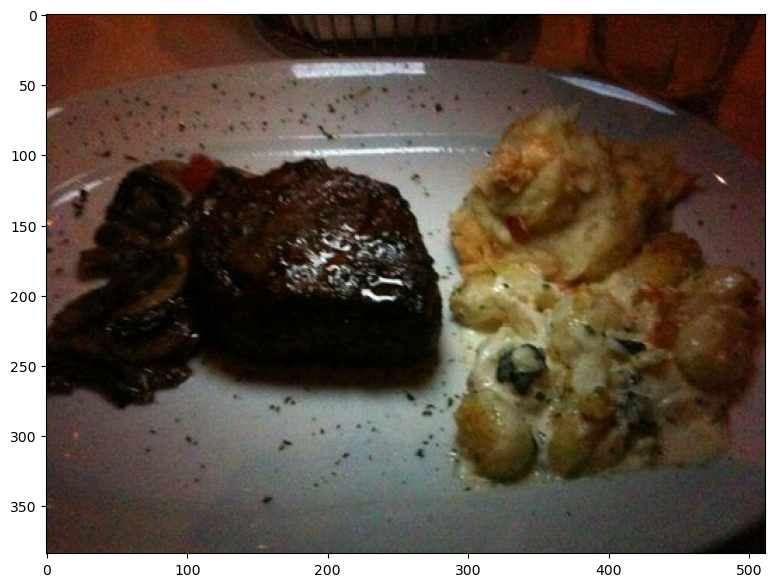

In [56]:
# getting paths of all images
image_path_list = list(image_path.glob("*/*/*.jpg"))

# select randomly from the image path list
random_image_path = random.choice(image_path_list)
random_image_class = random_image_path.parent.stem

# open image
img = Image.open(random_image_path)

# convert image to array
img_as_array = np.asarray(img)

# print metadata
print(f"Image Class: {random_image_class}")
print(f"Image Shape: {img_as_array.shape}") # height, width, color_channels

plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)

# Transforming data for use with a model
Before we use the image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader

In [57]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

__transforming data with `torchvision.transforms`__ <br>
__torchvision.transforms: https://pytorch.org/vision/0.9/transforms.html__ <br>
__Illustration of transforms: https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py__

In [58]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)), # resizes image to 64x64
    transforms.RandomHorizontalFlip(p=0.5), # flips the images randomly on the horizontal
    transforms.ToTensor() # turn the image into torch.Tensor
])

# seeing the effect on the img
data_transform(img)

tensor([[[0.1922, 0.1216, 0.1216,  ..., 0.3686, 0.3608, 0.3647],
         [0.2275, 0.1333, 0.1294,  ..., 0.3490, 0.3569, 0.3569],
         [0.2627, 0.1529, 0.1294,  ..., 0.3216, 0.3569, 0.3490],
         ...,
         [0.0431, 0.0784, 0.1176,  ..., 0.2431, 0.2314, 0.2196],
         [0.0353, 0.0392, 0.0510,  ..., 0.2510, 0.2431, 0.2196],
         [0.0353, 0.0275, 0.0275,  ..., 0.2627, 0.2549, 0.2314]],

        [[0.0549, 0.0392, 0.0431,  ..., 0.1137, 0.1137, 0.1137],
         [0.0667, 0.0431, 0.0431,  ..., 0.1176, 0.1137, 0.1098],
         [0.0745, 0.0510, 0.0392,  ..., 0.1294, 0.1176, 0.1216],
         ...,
         [0.0196, 0.0471, 0.1098,  ..., 0.1569, 0.1529, 0.1490],
         [0.0196, 0.0157, 0.0353,  ..., 0.1529, 0.1490, 0.1412],
         [0.0196, 0.0196, 0.0196,  ..., 0.1529, 0.1529, 0.1569]],

        [[0.0235, 0.0275, 0.0196,  ..., 0.0471, 0.0471, 0.0510],
         [0.0314, 0.0235, 0.0196,  ..., 0.0549, 0.0549, 0.0510],
         [0.0275, 0.0235, 0.0196,  ..., 0.0667, 0.0667, 0.

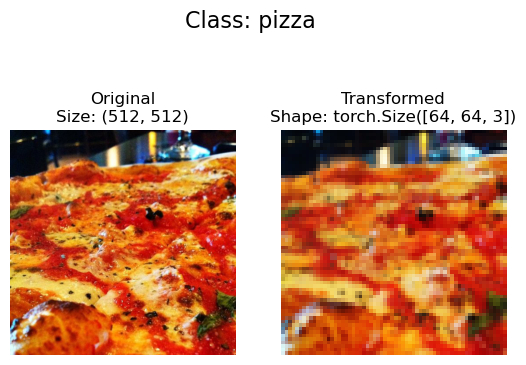

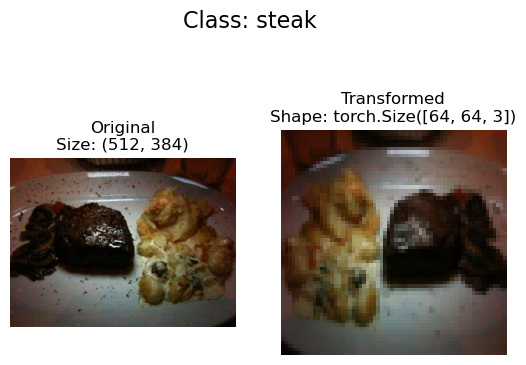

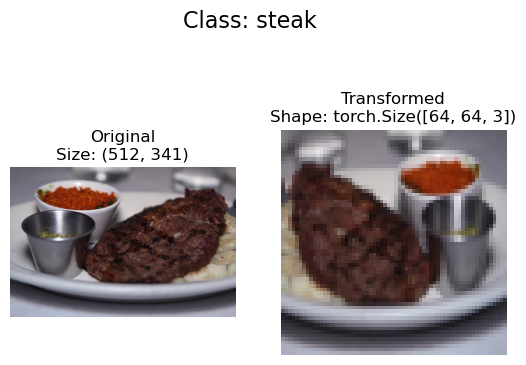

In [59]:
def plot_transformed_image(image_paths, transform, n=3, seed=None):
    """
    Selects random images from a path of images and loads/transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)

    random_img_paths = random.sample(image_paths, k=n)
    for image_path in random_img_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # plot original image
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # plot transformed image
            transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_image(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

# Loading custom data with pre-built functions and custom functions

__Option 1: Using ImageFolder__ <br>
__ImageFolder: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html__

In [60]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # transform for the data
                                  target_transform=None) # transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [61]:
# get class names as list
class_names = train_data.classes

# get class names as dict
class_dict = train_data.class_to_idx

class_names, class_dict

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [62]:
# index on train_data dataset to get he single image and label
img, label = train_data[0][0], train_data[0][1]

print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> color_channels, height, width
Permuted Shape: torch.Size([64, 64, 3]) -> height, width, color_channels


Text(0.5, 1.0, 'pizza')

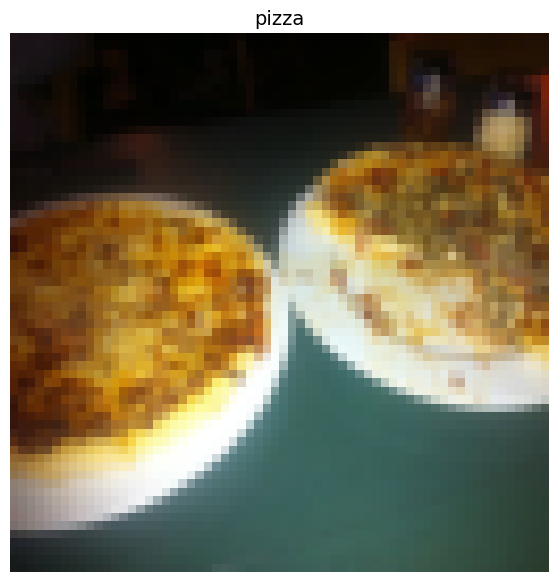

In [63]:
# rearrange dimensions for matplotlib
img_permute = img.permute(1, 2, 0)

# print out different shapes
print(f"Original Shape: {img.shape} -> color_channels, height, width")
print(f"Permuted Shape: {img_permute.shape} -> height, width, color_channels")

# plotting the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

__Creating DataLoaders__

In [64]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=False)

len(train_dataloader), len(test_dataloader)

(45, 15)

In [65]:
# iterating through the data loader
img, label = next(iter(train_dataloader))

print(f"Image Shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([5, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([5])


__Option 2: Creating a Custom Dataset__ <br>
All custom datasets in Pytorch subclass this: __https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset__


In [66]:
import torch
import os, pathlib
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [67]:
# create a helper function to get class names

# get class name from the train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(train_dir))])
class_names_found

['pizza', 'steak', 'sushi']

In [68]:
def find_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
    class_names_list = sorted([entry.name for entry in list(os.scandir(train_dir))])
    class_names_dict = {class_names_list[i]: i for i in range(len(class_names_list))}

    return class_names_list, class_names_dict

find_classes(dir=train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

creating a `custom dataset` for replicating the `ImageFolder` <br>
To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we would like to get data from) as well as the transform if we'd like to transform out data.
3. Create a several attributes:
> * paths - paths of out images
> * transform - the transform we'd like to use
> * classes - a list of the target classes
> * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem__()` method to return a given sample when passed as an index

In [69]:
class CustomImageDataset(Dataset):
    def __init__(self, targ_dir: str, transform=None):
        # get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # set up transform
        self.transform = transform
        # create class_names and class_to_idx attributes
        self.class_names, self.class_to_idx = find_classes(targ_dir)

    def load_image(self, index:int) -> Image.Image:
        "opens an image via a path and returns it"
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self) -> int:
        """returns the total number of samples"""
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """returns one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path name in format: folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # transform if necessary
        if self.transform:
            return self.transform(img), class_idx

        return img, class_idx # else we return untransformed data (X, y)

In [70]:
from torchvision import transforms

# creating transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [71]:
# creating instance of the CustomImageDataset
train_data_custom = CustomImageDataset(targ_dir=train_dir,
                                       transform=train_transforms)

test_data_custom = CustomImageDataset(targ_dir=test_dir,
                                      transform=test_transforms)

train_data_custom, test_data_custom # this does not give us very helpful result

(<__main__.CustomImageDataset at 0x31a0eeb10>,
 <__main__.CustomImageDataset at 0x31a0a1f50>)

In [72]:
# try seeing length
# remember: train_data and test_data we created using ImageFolder()

len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [73]:
# checking the attributes
train_data_custom.class_names, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [74]:
# creating a func to display random images
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    if n > 10:
        n = 10
        display_shape = False
        print(f"for display purposes we have capped n to 10")

    if seed:
        random.seed(seed)

    # get random samples
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize=(16, 8))

    # loop through the random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust image dimensions
        targ_image_permute = targ_image.permute(1, 2, 0)

        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_permute)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_permute.shape}"
        plt.title(title)

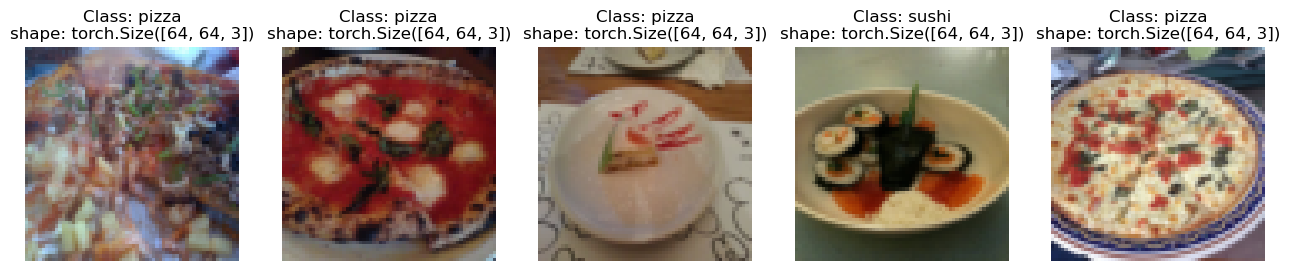

In [75]:
# using ImageFolder()
display_random_images(train_data, n=5, classes=class_names, seed=None)

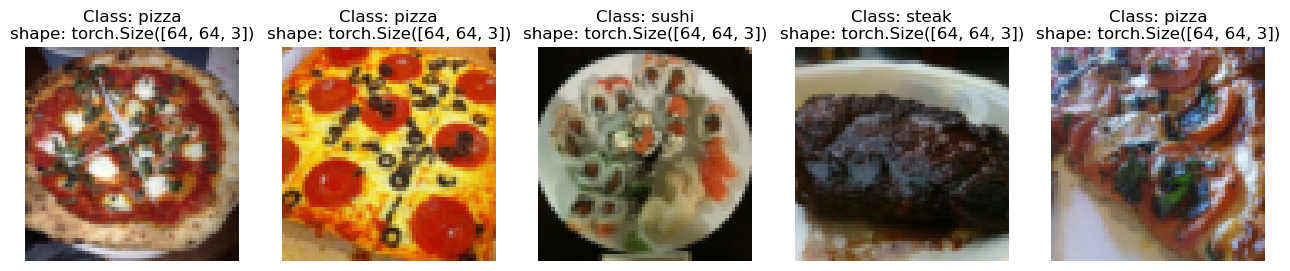

In [76]:
# using CustomImageDataset()
display_random_images(train_data_custom, n=5, classes=class_names, seed=None)

In [77]:
# creating data loaders with CustomImageDataset

from torch.utils.data import DataLoader

BATCH_SIZE = 5;

custom_train_dataloader = DataLoader(train_data_custom, batch_size=BATCH_SIZE, shuffle=True)
custom_test_dataloader = DataLoader(test_data_custom, batch_size=BATCH_SIZE, shuffle=False)


len(custom_train_dataloader), len(custom_test_dataloader)

(45, 15)

In [78]:
# check their shape
img_custom, trg_custom = next(iter(custom_train_dataloader))
img_custom.shape, trg_custom.shape

(torch.Size([5, 3, 64, 64]), torch.Size([5]))

# Data Augmentation
Data augmentation is the process of artificially generating new data from existing data, primarily to train new machine learning (ML) models. ML models require large and varied datasets for initial training, but sourcing sufficiently diverse real-world datasets can be challenging because of data silos, regulations, and other limitations. Data augmentation artificially increases the dataset by making small changes to the original data.

__Trivial Augment: https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html__

In [79]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

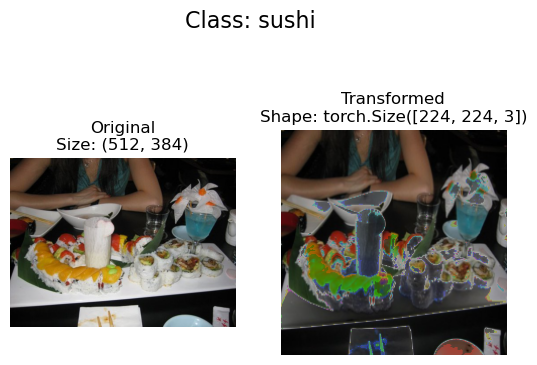

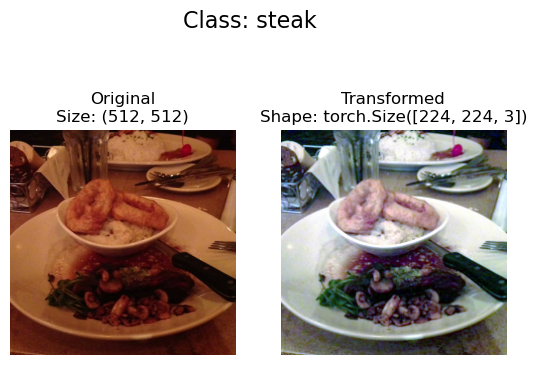

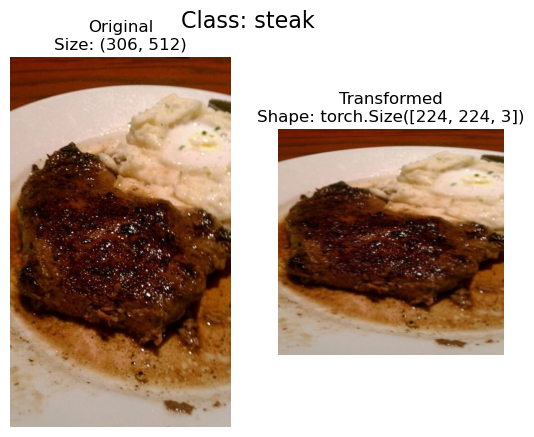

In [80]:
plot_transformed_image(image_path_list, train_transform, n = 3, seed=None)

# Building FoodVision Mini to classify (pizza, sushi, steak) images
We will first build model without data augmentation.

In [81]:
# we will
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [82]:
# load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

In [83]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
            ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.fc(x)

In [84]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [85]:
# tring a forward pass on a single image to get to know the shape of the fc layer
# image_batch, label_batch = next(iter(train_dataloader_simple))
# image_batch.shape, label_batch.shape

# image_batch = image_batch.to(device)

# model_0(image_batch)

With torchinfo we can get the summary of the model <br>
__`torchinfo`: https://github.com/TylerYep/torchinfo__

In [86]:
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [87]:
from torchinfo import summary

model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)
# from here we can see the shape of the fc layer to set
summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

In [88]:
# func to calc accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return (correct/len(y_true)) * 100

In [89]:
# train step functions
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # put the model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for X_train, y_train in dataloader:
        # sending data to target device
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # forward pass
        y_logits = model(X_train)

        # calc loss, acc
        loss = loss_fn(y_logits, y_train)
        train_loss += loss.item()
        train_acc += accuracy_fn(y_train, torch.argmax(torch.softmax(y_logits, dim=1), dim=1))

        # optimizer zero grad
        optimizer.zero_grad()

        # loss backwards
        loss.backward()

        # optimizer step
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [90]:
# test step function
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module):
    test_loss, test_acc = 0, 0
    # set model on eval mode
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in dataloader:
            # sending data to target device
            X_test, y_test = X_test.to(device), y_test.to(device)

            # forward pass
            y_logits = model(X_test)

            # calc loss, acc
            test_loss += loss_fn(y_logits, y_test).item()
            test_acc += accuracy_fn(y_test, torch.argmax(torch.softmax(y_logits, dim=1), dim=1))

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [91]:
# train function for training he model

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5):

    # creating a empty result dictionary
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model_0, train_dataloader_simple, loss_fn, optimizer)
        test_loss, test_acc = test_step(model_0, test_dataloader_simple, loss_fn)
        print(f"Epoch:{epoch}\tTrain_Loss:{train_loss:.4f}\tTrain_Acc:{train_acc:.4f}\tTest_Loss:{test_loss:.4f}\tTest_Acc:{test_acc:.4f}")

        # update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [92]:
# set random seed
torch.manual_seed(42)
torch.mps.manual_seed(42)

# set number of epochs
EPOCHS = 5

# recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device)

# seeting up loss function
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.Adam(params=model_0.parameters())

model_0_results = train(model_0, train_dataloader_simple, test_dataloader_simple, loss_fn, optimizer, EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0	Train_Loss:1.1063	Train_Acc:30.4688	Test_Loss:1.0983	Test_Acc:31.1553
Epoch:1	Train_Loss:1.0995	Train_Acc:33.2031	Test_Loss:1.0698	Test_Acc:54.1667
Epoch:2	Train_Loss:1.0863	Train_Acc:49.2188	Test_Loss:1.0800	Test_Acc:52.2727
Epoch:3	Train_Loss:1.0826	Train_Acc:41.0156	Test_Loss:1.0599	Test_Acc:57.2917
Epoch:4	Train_Loss:1.0631	Train_Acc:41.4062	Test_Loss:1.0611	Test_Acc:55.3977


In [93]:
model_0_results

{'train_loss': [1.106342375278473,
  1.0994887351989746,
  1.0862815827131271,
  1.082587331533432,
  1.063058689236641],
 'train_acc': [30.46875, 33.203125, 49.21875, 41.015625, 41.40625],
 'test_loss': [1.0983144044876099,
  1.069840908050537,
  1.0800275405248005,
  1.0598626534144084,
  1.0611249605814617],
 'test_acc': [31.15530303030303,
  54.166666666666664,
  52.27272727272727,
  57.291666666666664,
  55.39772727272727]}

Read this for interpretting the loss curve: <br>
__https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic__ <br>
Read this to understand how to handle underfitting and overfitting <br>
__https://medium.com/@datascienceeurope/do-you-know-overfitting-and-underfitting-f27f87ac2f37__

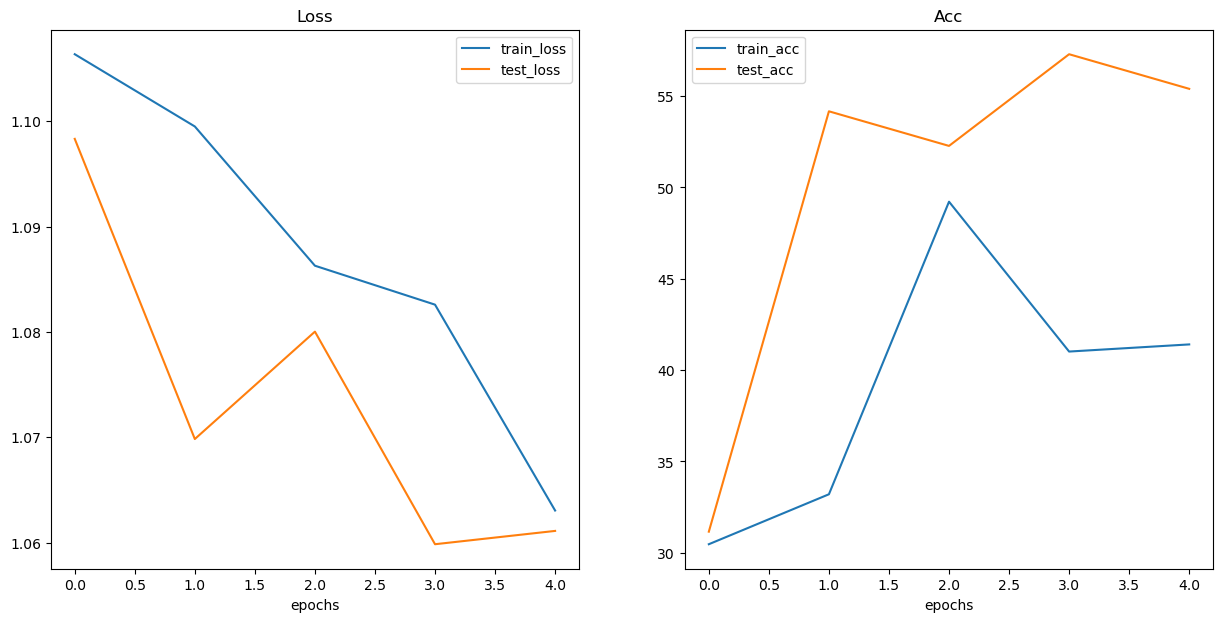

In [94]:
# plotting the loss curve
def plot_loss_curve(results: Dict[str, List[float]]):
    train_loss = results["train_loss"]
    train_acc = results["train_acc"]
    test_loss = results["test_loss"]
    test_acc = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    # setting up plot
    plt.figure(figsize=(15, 7))

    # plot the loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()

    # plot the acc
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Acc")
    plt.xlabel("epochs")
    plt.legend()

plot_loss_curve(model_0_results)

__OverFitting, UnderFitting__
![title](loss_curves.jpeg)

__Methods to deal with Underfitting__
![title](underfitting.jpeg)

__Methods to deal with OverFitting__
![title](overfitting.jpeg)

Since our model_0 have test_accuracy of 52% means our model_0 have underfitted. <br>
To deal with these we try to use data augmentation.

In [95]:
# creating transforms for data augmentation

from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# we dont augment test data
test_transforms_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [96]:
# making dataset using new transform

from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_augmented = datasets.ImageFolder(root=test_dir,
                                           transform=test_transforms_trivial)

len(train_data_augmented), len(test_data_augmented)

(225, 75)

In [97]:
# making dataloaders

import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augment = DataLoader(dataset=train_data_augmented,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      num_workers=NUM_WORKERS)

test_dataloader_augment = DataLoader(dataset=test_data_augmented,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)



In [98]:
# create model_1
torch.manual_seed(42)
torch.mps.manual_seed(42)

HIDDEN_UNITS = 10

model_1 = TinyVGG(input_shape=3,
                  hidden_units=HIDDEN_UNITS,
                  output_shape=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [99]:
# training the model
torch.manual_seed(42)
torch.mps.manual_seed(42)

# num of epochs
EPOCHS = 5

# setting up loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

model_1_results = train(model_1, train_dataloader_augment, test_dataloader_augment, loss_fn, optimizer, EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0	Train_Loss:1.0439	Train_Acc:45.7031	Test_Loss:1.0611	Test_Acc:55.3977
Epoch:1	Train_Loss:1.0413	Train_Acc:45.7031	Test_Loss:1.0611	Test_Acc:55.3977
Epoch:2	Train_Loss:1.0382	Train_Acc:45.7031	Test_Loss:1.0611	Test_Acc:55.3977
Epoch:3	Train_Loss:1.0383	Train_Acc:57.8125	Test_Loss:1.0611	Test_Acc:55.3977
Epoch:4	Train_Loss:1.0377	Train_Acc:45.7031	Test_Loss:1.0611	Test_Acc:55.3977


In [100]:
model_1_results

{'train_loss': [1.0439305528998375,
  1.0412837639451027,
  1.0382279306650162,
  1.0382853150367737,
  1.0377300083637238],
 'train_acc': [45.703125, 45.703125, 45.703125, 57.8125, 45.703125],
 'test_loss': [1.0611249605814617,
  1.0611249605814617,
  1.0611249605814617,
  1.0611249605814617,
  1.0611249605814617],
 'test_acc': [55.39772727272727,
  55.39772727272727,
  55.39772727272727,
  55.39772727272727,
  55.39772727272727]}

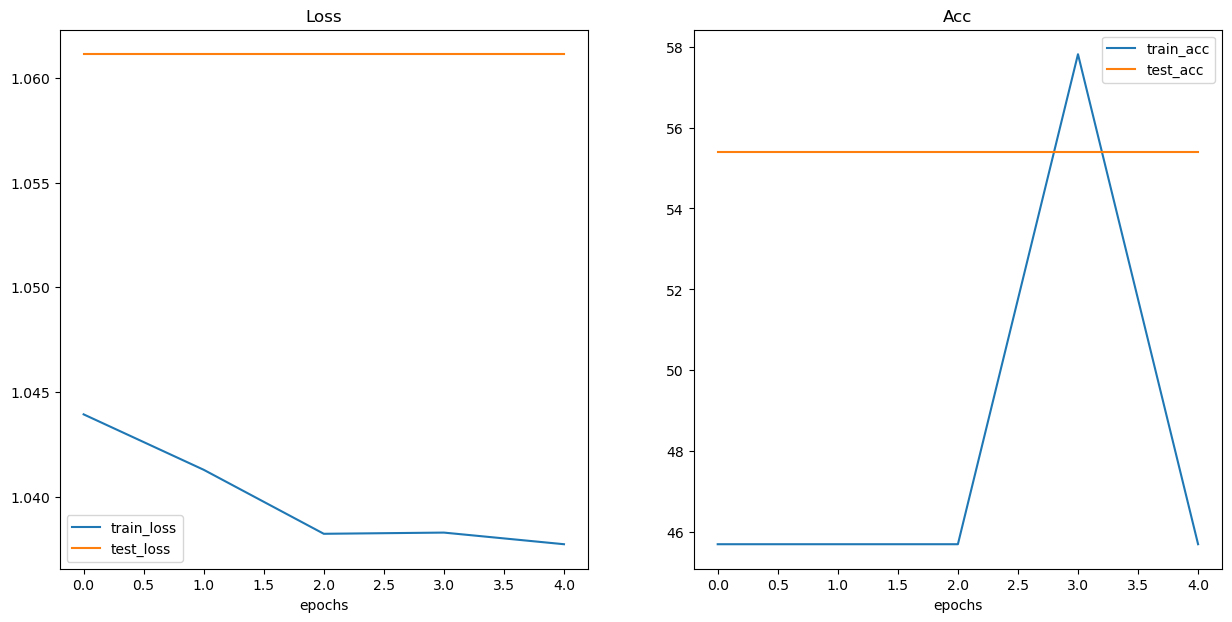

In [101]:
# plotting loss curves
plot_loss_curve(model_1_results)

# Comparing models with and without Data Augmentation

In [102]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106342,30.468750,1.098314,31.155303
1,1.099489,33.203125,1.069841,54.166667
2,1.086282,49.218750,1.080028,52.272727
3,1.082587,41.015625,1.059863,57.291667
4,1.063059,41.406250,1.061125,55.397727


In [103]:
model_1_df = pd.DataFrame(model_1_results)
model_1_df

,train_loss,train_acc,test_loss,test_acc
0,1.043931,45.703125,1.061125,55.397727
1,1.041284,45.703125,1.061125,55.397727
2,1.038228,45.703125,1.061125,55.397727
3,1.038285,57.812500,1.061125,55.397727
4,1.037730,45.703125,1.061125,55.397727


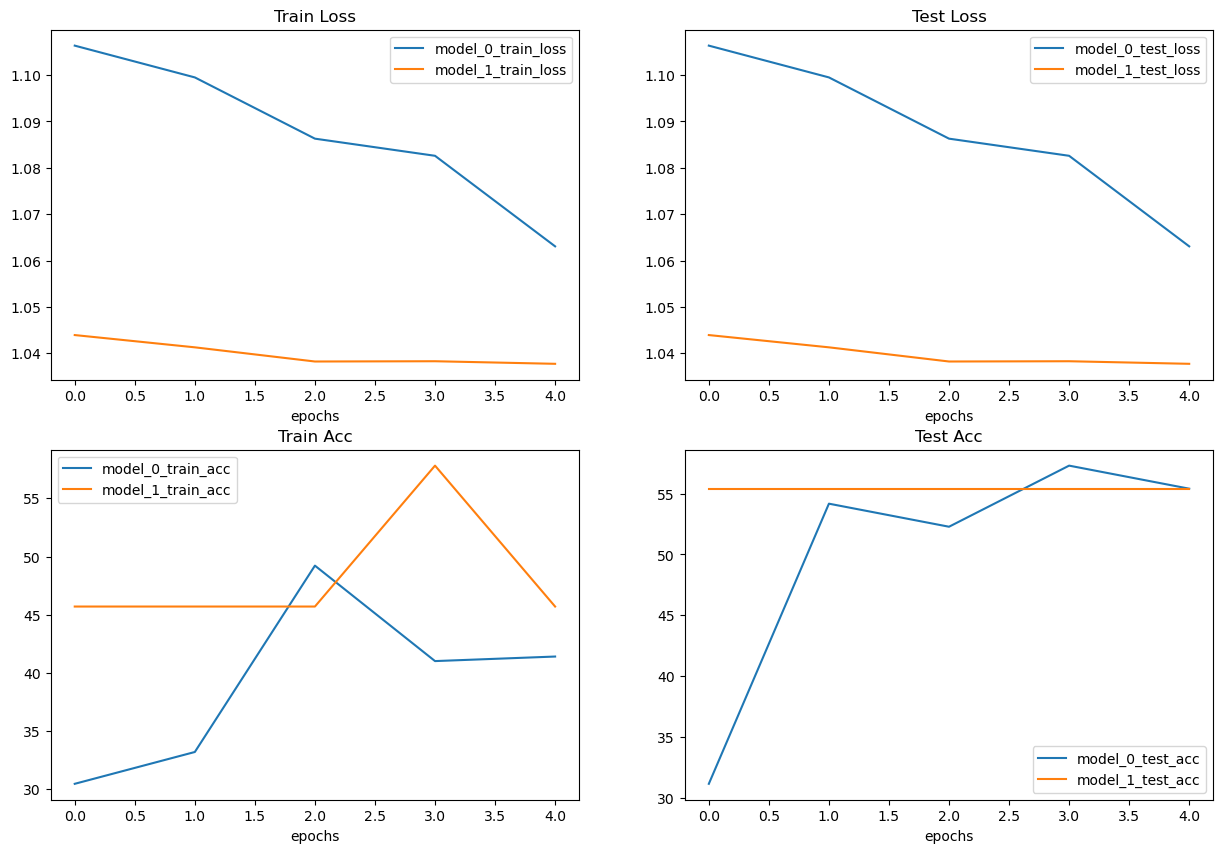

In [104]:
# plotting the loss curves of both models in one plot
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="model_0_train_loss")
plt.plot(epochs, model_1_df["train_loss"], label="model_1_train_loss")

plt.title("Train Loss")
plt.xlabel("epochs")
plt.legend()

# plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["train_loss"], label="model_0_test_loss")
plt.plot(epochs, model_1_df["train_loss"], label="model_1_test_loss")

plt.title("Test Loss")
plt.xlabel("epochs")
plt.legend()

# plot train acc
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="model_0_train_acc")
plt.plot(epochs, model_1_df["train_acc"], label="model_1_train_acc")

plt.title("Train Acc")
plt.xlabel("epochs")
plt.legend()

# plot test acc
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="model_0_test_acc")
plt.plot(epochs, model_1_df["test_acc"], label="model_1_test_acc")

plt.title("Test Acc")
plt.xlabel("epochs")
plt.legend()

# Making prediction on custom data

In [105]:
# download custom image
import requests

# setup custom image path
custom_image_path = data_path / "custom_img.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path} ...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists")

To read the image we can use: <br>
__read_image(): https://pytorch.org/vision/main/generated/torchvision.io.read_image.html__<br>

In [106]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor: {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor: tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype

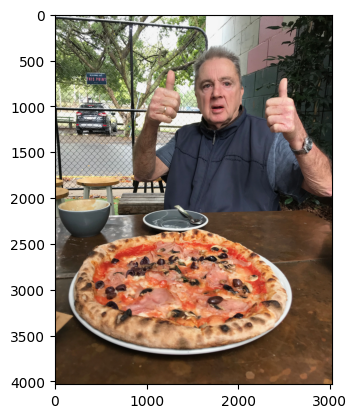

In [57]:
# plotting the image
plt.imshow(custom_image_uint8.permute(1, 2, 0))

lets tranform the image
1. Convert dtype to float32
2. Resize the image to 3x64x64

In [58]:
# load the image and convert to torch.float32
custom_image_tensor = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.0
print(f"Custom image tensor: {custom_image_tensor}")
print(f"Custom image shape: {custom_image_tensor.shape}")
print(f"Custom image dtype: {custom_image_tensor.dtype}")

Custom image tensor: tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

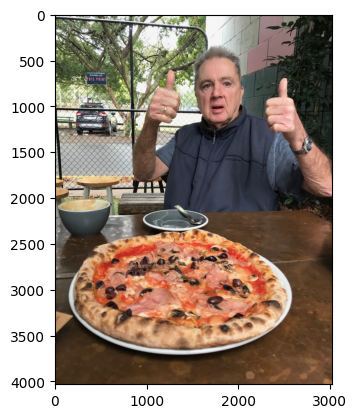

In [59]:
plt.imshow(custom_image_tensor.permute(1, 2, 0))

In [60]:
# resizing the image
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

custom_image_tensor = custom_image_transform(custom_image_tensor)
print(f"Custom image tensor shape: {custom_image_tensor.shape}")

Custom image tensor shape: torch.Size([3, 64, 64])


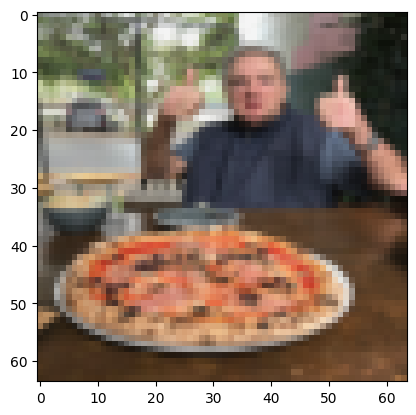

In [61]:
# now lets try to plot
plt.imshow(custom_image_tensor.permute(1,2,0))

In [65]:
# now lets get the prediction on the image

custom_image_tensor = custom_image_tensor.to(device)

model_1.eval()
with torch.inference_mode():
    # we need to unsqueeze becuase we want a batch dimension
    y_logits = model_1(custom_image_tensor.unsqueeze(0))
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

class_names[y_pred] # we get the correct output

'pizza'

In [66]:
# making one function that takes a model and image and all the predictions
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform=None,
                        device=device):
    # load the image
    img = torchvision.io.read_image(image_path).type(torch.float32)
    img /= 255

    # transform the image
    if transform:
        img = transform(img)

    # putting model and img on the same device
    model = model.to(device)
    img = img.to(device)

    # making prediction
    model.eval()
    with torch.inference_mode():
        y_logits = model(img.unsqueeze(0))
        y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    # plot the image
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f"Pred: {class_names[y_pred]}")
    plt.axis(False)

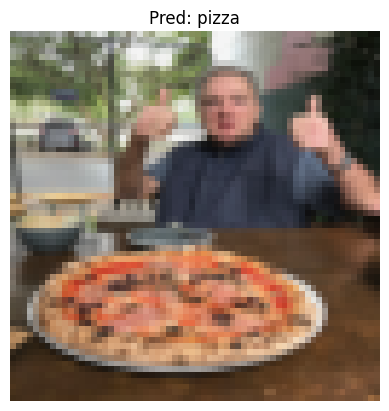

In [67]:
pred_and_plot_image(model_1, custom_image_path, class_names, custom_image_transform)